# Steam Data Exploration

Here, we will have a initial look of the links between the columns and the rating of a game.



## Import Library and Inspect Data


In [1]:
import itertools
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

plt.style.use('default')
plt.rcdefaults()

In [2]:
df = pd.read_csv('../data/cleaned/steam_clean.csv')
df.head()

appid                       name release_date             owners    ccu  \
0     10             Counter-Strike   2000-11-01  10000000-20000000  12484   
1     20      Team Fortress Classic   1999-04-01   5000000-10000000     86   
2     30              Day of Defeat   2003-05-01    1000000-2000000    127   
3     40         Deathmatch Classic   2001-06-01      100000-200000      5   
4     50  Half-Life: Opposing Force   1999-11-01    2000000-5000000    122   

   price                                          languages  english  \
0   8.19  English, French, German, Italian, Spanish - Sp...        1   
1   3.99  English, French, German, Italian, Spanish - Sp...        1   
2   3.99  English, French, German, Italian, Spanish - Spain        1   
3   3.99  English, French, German, Italian, Spanish - Sp...        1   
4   3.99                    English, French, German, Korean        1   

          developer publisher  ...  genres                 steamspy_tags  \
0             Valve     Valve  ...  Action        Action;FPS;Multiplayer   
1             Valve     Valve  ...  Action        Action;FPS;Multiplayer   
2             Valve     Valve  ...  Action  FPS;World War II;Multiplayer   
3             Valve     Valve  ...  Action            Action;FPS;Classic   
4  Gearbox Software     Valve  ...  Action            FPS;Action;Classic   

  achievements positive_ratings negative_ratings  average_playtime  \
0            0           212609             5405              9302   
1            0             6242              978              1400   
2            0             5548              612              1624   
3            0             2133              474              2425   
4            0            16547              839              1282   

   median_playtime    ratings  median_owners  total_ratings  
0              181  96.315702     15000000.0         218014  
1               20  83.474384      7500000.0           7220  
2               20  86.808615      1500000.0           6160  
3               11  77.986329       150000.0           2607  
4              127  92.656284      3500000.0          17386  

[5 rows x 23 columns]

## Data Preprocessing

* `Language and Platform`: we'd like to focus on English games that operate on Windows, since they take majority of the steam games.
* `release year`: compared to release date, we're more interested in analysing the year of that game released. Since it's better for us to further analyse the performance.
* then keep the columns we want and create a new dataframe for `Exploratory Data Analysis`.

In [3]:
def remove_non_english(df):
    """
    Remove non-english rows
    """
    # keep only rows marked as supporting english
    df = df[df['english'] == 1].copy()
    
    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    # remove english column, now redundant
    df = df.drop('english', axis=1)
    
    return df


# convert release_date to datetime type and create separate column for release_year
df['release_date'] = df['release_date'].astype('datetime64[ns]')
df['release_year'] = df['release_date'].apply(lambda x: x.year)

# remove non-windows and non-english games
df[df['platforms'].str.contains('windows')].drop('platforms', axis=1)
df = remove_non_english(df)

# create a new dataframe and keep the columns we want only
data = df[[
            'appid',
            'name', 
            'release_year',
            'median_owners',
            'ccu',
            'price',
            'developer',
            'publisher',
            'categories',
            'genres',
            'steamspy_tags',
            'achievements',
            'total_ratings',
            'ratings',
            'average_playtime',
            'median_playtime'
]]



data.head()

appid                       name  release_year  median_owners    ccu  \
0     10             Counter-Strike          2000     15000000.0  12484   
1     20      Team Fortress Classic          1999      7500000.0     86   
2     30              Day of Defeat          2003      1500000.0    127   
3     40         Deathmatch Classic          2001       150000.0      5   
4     50  Half-Life: Opposing Force          1999      3500000.0    122   

   price         developer publisher  \
0   8.19             Valve     Valve   
1   3.99             Valve     Valve   
2   3.99             Valve     Valve   
3   3.99             Valve     Valve   
4   3.99  Gearbox Software     Valve   

                                          categories  genres  \
0  Multi-player;PvP;Online PvP;Shared/Split Scree...  Action   
1  Multi-player;PvP;Online PvP;Shared/Split Scree...  Action   
2              Multi-player;Valve Anti-Cheat enabled  Action   
3  Multi-player;PvP;Online PvP;Shared/Split Scree...  Action   
4  Single-player;Multi-player;Valve Anti-Cheat en...  Action   

                  steamspy_tags  achievements  total_ratings    ratings  \
0        Action;FPS;Multiplayer             0         218014  96.315702   
1        Action;FPS;Multiplayer             0           7220  83.474384   
2  FPS;World War II;Multiplayer             0           6160  86.808615   
3            Action;FPS;Classic             0           2607  77.986329   
4            FPS;Action;Classic             0          17386  92.656284   

   average_playtime  median_playtime  
0              9302              181  
1              1400               20  
2              1624               20  
3              2425               11  
4              1282              127

## Data Overview

Now, we'll focus on a few columns including genres, owners, price, release year and ratings.

We can quickly inspect and compare kernel density estimation (KDE) and scatter plots representing the data using seaborn, noting any patterns and probable linkages in the data. To compare the owners and total_ratings columns on a more appropriate scale, we'll apply a logarithmic adjustment to them.

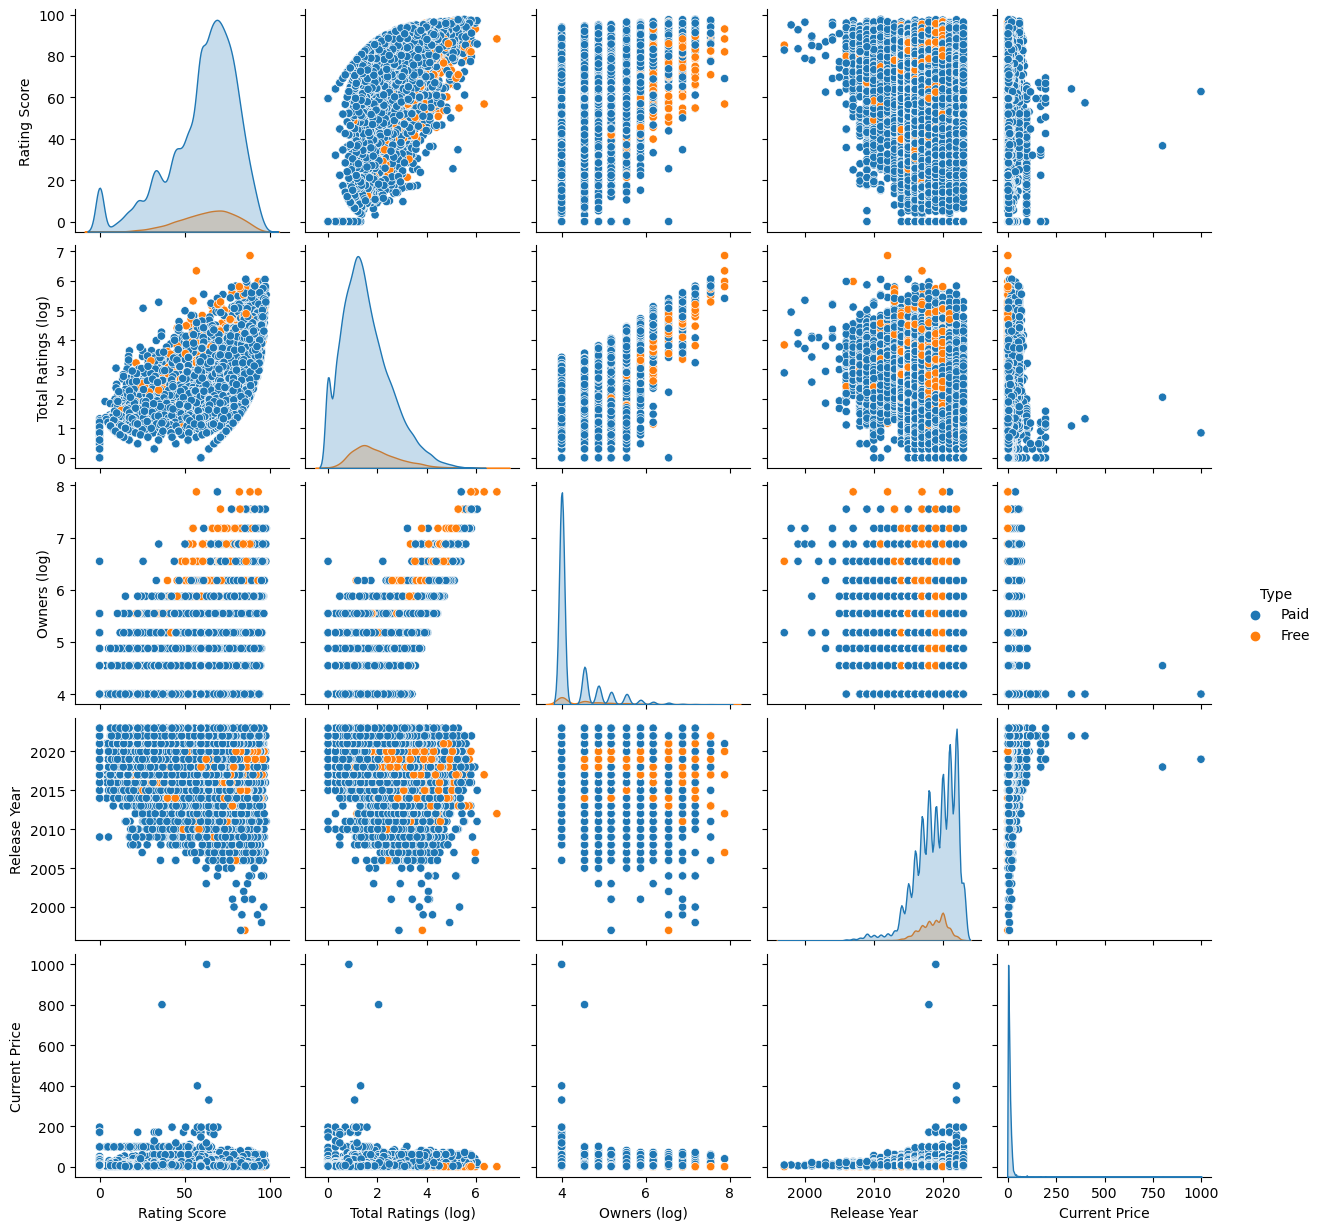

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Create a column to split free vs paid games
data['type'] = 'Free'
data.loc[data['price'] > 0, 'type'] = 'Paid'

# ensure no 0s in cells
df = data[(data['median_owners'] > 0) & (data['total_ratings'] > 0)].copy()

eda_df = pd.DataFrame(zip(df['ratings'],
                          np.log10(df['total_ratings']),
                          np.log10(df['median_owners']),
                          df['release_year'],
                          df.price,
                          df['type']
                         ),
                      columns=['Rating Score', 'Total Ratings (log)', 'Owners (log)', 'Release Year', 'Current Price', 'Type'])

sns.pairplot(eda_df, hue='Type')
plt.show()

From this visualisation, we can make some initial observations:

- There are more paid games than free games
- Paid games have much higher ratings than free games
- Ratings for free games are more spread out
- More owners for paid games than free games
- The more owners of a game, the more ratings it has
- More paid games are released recently
- More recent games are more expensive

Based on the observations, we can make some initial conlusions:
- Ratings decreases overtime, suggesting that the newer the game is, the lower ratings it has.
- As price increases, ratings increase, suggesting that people are more likely to rate higher if they spend more money on that game.
- Higher ratings will be resulted from more owners, suggesting that games with more owners will gain higher ratings.

However, we cannot draw conclusions completely at this stage, we need further analysis on each factor including release year, generes, owners, pricing and delopers and publishers.

Now, let's do a simple heatmap to see the correlations between each columns


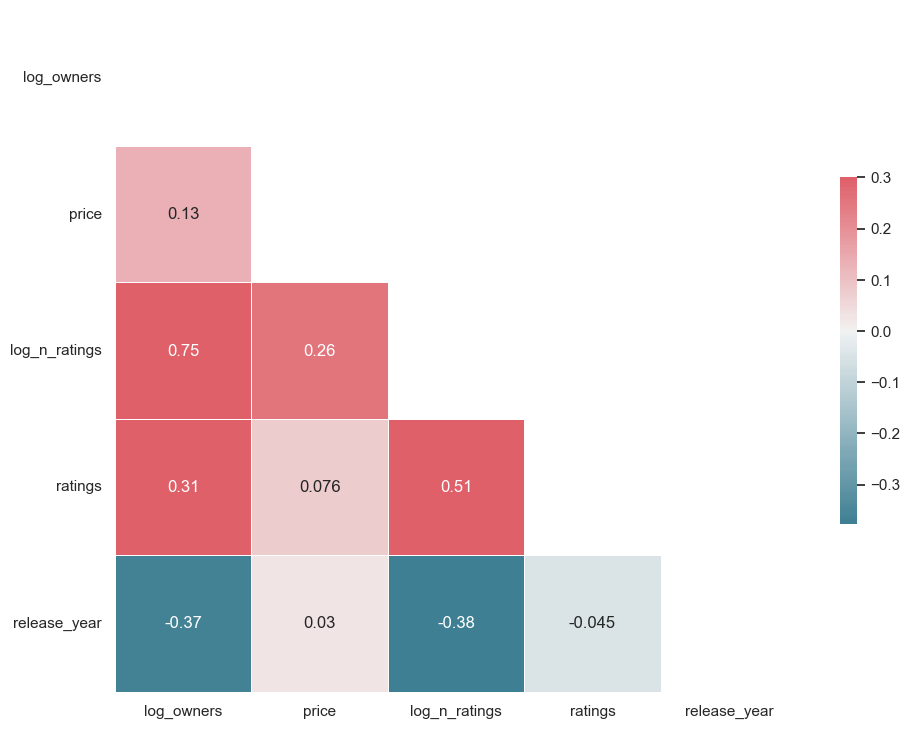

In [5]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style='white')
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(11,9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    
    plt.yticks(rotation=0)
    plt.show()
    plt.rcdefaults()

corr_df = data.copy()
corr_df['log_owners'] = np.log10(corr_df['median_owners'])
corr_df['log_n_ratings'] = np.log10(corr_df['total_ratings'])

plot_correlation_heatmap(corr_df[['log_owners', 'price', 'log_n_ratings', 'ratings', 'release_year']])

Based on the initial correlations we found, let's do a closer check of each factor.

## Release Year

From the KDE we produced above, we can notice that rating scores seem to decrease overtime, but the number of releases has been increasing overtime. Now let's see this trend by using plots.



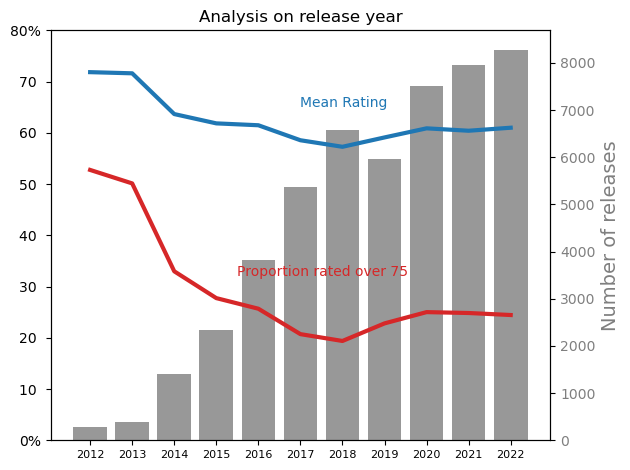

In [6]:
df = data.copy()

# we use 3/4 of total score (i.e 75) as an indicator of high ratings
rating_threshold = 75


# store useful values to each list
years = []
proportions = []
totals = []
avg_ratings = []
max_ratings = []


for year in sorted(df['release_year'].unique()):
    if year < 2012 or year > 2022:
        continue
    
    year_data = df[df['release_year'] == year]
    total = year_data.shape[0]
    high_rating = year_data[year_data['ratings'] >= rating_threshold].shape[0]
    avg_rating = year_data['ratings'].mean() / 100
    
    years.append(year)
    totals.append(total)
    proportions.append(high_rating/total)
    avg_ratings.append(avg_rating)
    

# plot_1: trendlines 
fig, plt1 = plt.subplots()
plt1.set_zorder(1)
plt1.patch.set_visible(False)

plt1.plot(avg_ratings, color='tab:blue', label='Average Rating', linewidth=3)
plt1.plot(proportions, color='tab:red', label=f'Proportion of games rated over {rating_threshold}', linewidth=3)

x_pos = np.arange(len(years))
plt1.set_xticks(x_pos)
plt1.set_xticklabels(years, fontsize=8)
plt1.set_yticks(np.arange(0, 0.9, 0.1))
plt1.set_yticklabels(['0%', '10 ', '20 ', '30 ', '40 ', '50 ', '60 ', '70 ', '80%'])

plt1.text(5, 0.65, 'Mean Rating', color='tab:blue')
plt1.text(3.5, 0.32, 'Proportion rated over 75', color='tab:red')

# plot_2: bar chart
plt2 = plt1.twinx()
color = 'tab:gray'
plt2.bar(x_pos, totals, color=color, alpha=.8)

plt2.set_ylabel('Number of releases', color=color, fontsize=14)
plt2.tick_params(axis='y', labelcolor=color)
plt2.set_title('Analysis on release year')

fig.tight_layout()
plt.show()

#### Conclusions:

1. Number of releases does increase overtime with a short drop between 2018 and 2019 which is not significant.

2. The mean rating dropped approximately by 10% in total, while there is a dramatic decrease between 2013 and 2014.

3. After 2013, under half of games are scored over 75, suggesting that high ratings are less likely to occur overtime.

## Categories, Genres and Steamspy_tags

Here, we want to draw a wordcloud to see which genres, categories or tags are more relevant. Also, we will focus on the tags for successful game. By defining successful games, we use "ratings >= 75" as an indicator.

In [7]:
data[data["ratings"] >= 75][["appid","name","categories","genres","steamspy_tags"]].head()

appid                       name  \
0     10             Counter-Strike   
1     20      Team Fortress Classic   
2     30              Day of Defeat   
3     40         Deathmatch Classic   
4     50  Half-Life: Opposing Force   

                                          categories  genres  \
0  Multi-player;PvP;Online PvP;Shared/Split Scree...  Action   
1  Multi-player;PvP;Online PvP;Shared/Split Scree...  Action   
2              Multi-player;Valve Anti-Cheat enabled  Action   
3  Multi-player;PvP;Online PvP;Shared/Split Scree...  Action   
4  Single-player;Multi-player;Valve Anti-Cheat en...  Action   

                  steamspy_tags  
0        Action;FPS;Multiplayer  
1        Action;FPS;Multiplayer  
2  FPS;World War II;Multiplayer  
3            Action;FPS;Classic  
4            FPS;Action;Classic

In [8]:
# first, define some functions for further use

def getTerm(data, variable):
    '''
    Get certain genre from the string
    '''
    terms = {}
    for line in data[variable].tolist():
        if ";" in line:
            line = line.split(";")
        else:
            line = [line]
        for x in line:
            if x not in terms:
                terms[x] = 1
            else:
                terms[x] += 1
    
    terms = {x:y for x, y in sorted(terms.items(), key = lambda x: x[1], reverse = True)}
    
    return terms


def splitTerm(data, variable, terms):
    '''
    Split each term in the string
    '''
    x_split = {key:[] for key in terms.keys()}
    for x in data[variable]:
        if ";" in x:
            x = x.split(";")
        else:
            x = [x]
        for key in x_split.keys():
            if key in x:
                x_split[key].append(1)
            else:
                x_split[key].append(0)
    
    x_data = pd.DataFrame(x_split)
    
    data_add = pd.merge(data, x_data , on = data.index)
    data_add.drop("key_0", axis = 1, inplace = True)
    
    return data_add

def drawWordCloud(freq_dict):
    '''
    Draw wordcloud for genres based on frequency
    '''
    wc = wordcloud.WordCloud(background_color="white", max_font_size=100, max_words=100, random_state=0).generate_from_frequencies(freq_dict)
    plt.figure(figsize=[8,6])
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off");

In [9]:
# define the terms we will use by using the functions above

cat_term = getTerm(data, "categories")
gen_term = getTerm(data, "genres")
tag_term = getTerm(data, "steamspy_tags")

data = splitTerm(data, "categories", cat_term)
data = splitTerm(data, "genres", gen_term)
data = splitTerm(data, "steamspy_tags", tag_term)

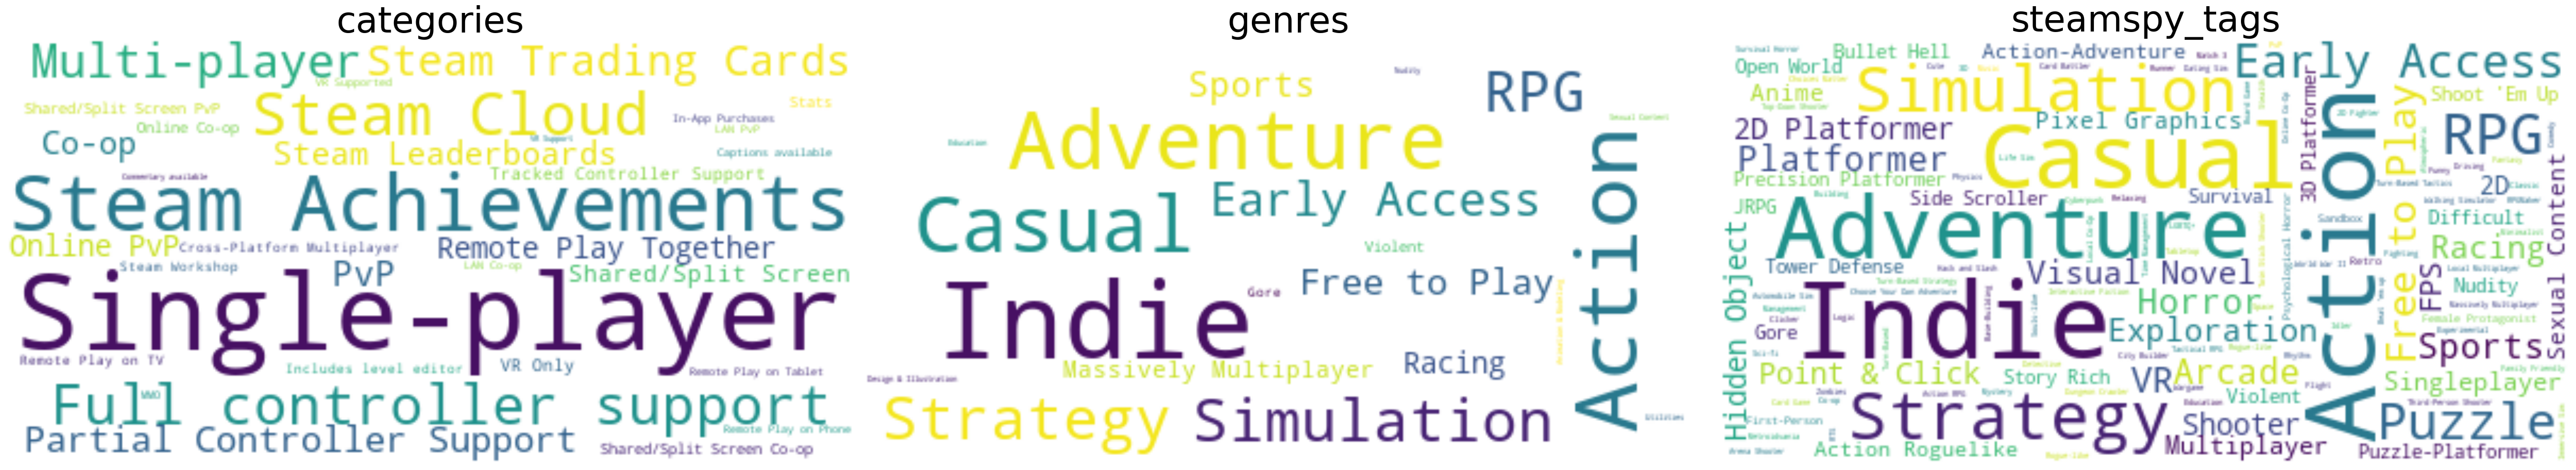

In [10]:
fig = plt.figure(figsize=[50,20])
list_term = [cat_term, gen_term, tag_term]
titles = ["categories", "genres", "steamspy_tags"]
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    wc = wordcloud.WordCloud(background_color="white", max_font_size=50, random_state=0).generate_from_frequencies(list_term[i-1])
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    ax.set_title(titles[i-1], size=50)
        
plt.tight_layout()
plt.show();

Now, we will focus on the 'popular' categories and genres as appeared on the wordcloud, and we will remove steamspy_tags as it overlaps with genres and categories.

In [22]:
# only focus on main categories
cat_cols = [
    # 'Local Multi-Player',
    # 'MMO',
    # 'Mods',
    # 'Multi-player',
    # 'Online Co-op',
    # 'Online Multi-Player',
    'Single-player'
]

# only keeping 'main' genres appeared on the steam store website
gen_cols = [
    # 'Accounting',
    'Action',
    'Adventure',
    # 'Animation & Modeling',
    # 'Audio Production',
    'Casual',
    # 'Design & Illustration',
    # 'Documentary',
    # 'Early Access',
    # 'Education',
    # 'Free to Play',
    # 'Game Development',
    # 'Gore',
    'Indie',
    'Massively Multiplayer',
    # 'Nudity',
    # 'Photo Editing',
    'RPG',
    'Racing',
    # 'Sexual Content',
    'Simulation',
    # 'Software Training',
    'Sports',
    'Strategy'
    # 'Tutorial',
    # 'Utilities',
    # 'Video Production',
    # 'Violent',
    # 'Web Publishing'
]





def get_unique(series):
    """Get unique values from a Pandas series"""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # find unique genre names
    gen_cols = get_unique(df['genres'])
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # remove "non-games" based on genre
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    
    return df


In [12]:
df = process_cat_gen_tag(data)
df.to_csv('../data/cleaned/data_for_EDA.csv', index=False)

df.head()

appid                       name  release_year  median_owners    ccu  \
0     10             Counter-Strike          2000     15000000.0  12484   
1     20      Team Fortress Classic          1999      7500000.0     86   
2     30              Day of Defeat          2003      1500000.0    127   
3     40         Deathmatch Classic          2001       150000.0      5   
4     50  Half-Life: Opposing Force          1999      3500000.0    122   

   price         developer publisher  genres  achievements  ...  action  \
0   8.19             Valve     Valve  Action             0  ...       1   
1   3.99             Valve     Valve  Action             0  ...       1   
2   3.99             Valve     Valve  Action             0  ...       1   
3   3.99             Valve     Valve  Action             0  ...       1   
4   3.99  Gearbox Software     Valve  Action             0  ...       1   

   adventure  casual  indie massively_multiplayer  rpg  racing  simulation  \
0          0       0      0                     0    0       0           0   
1          0       0      0                     0    0       0           0   
2          0       0      0                     0    0       0           0   
3          0       0      0                     0    0       0           0   
4          0       0      0                     0    0       0           0   

   sports  strategy  
0       0         0  
1       0         0  
2       0         0  
3       0         0  
4       0         0  

[5 rows x 526 columns]

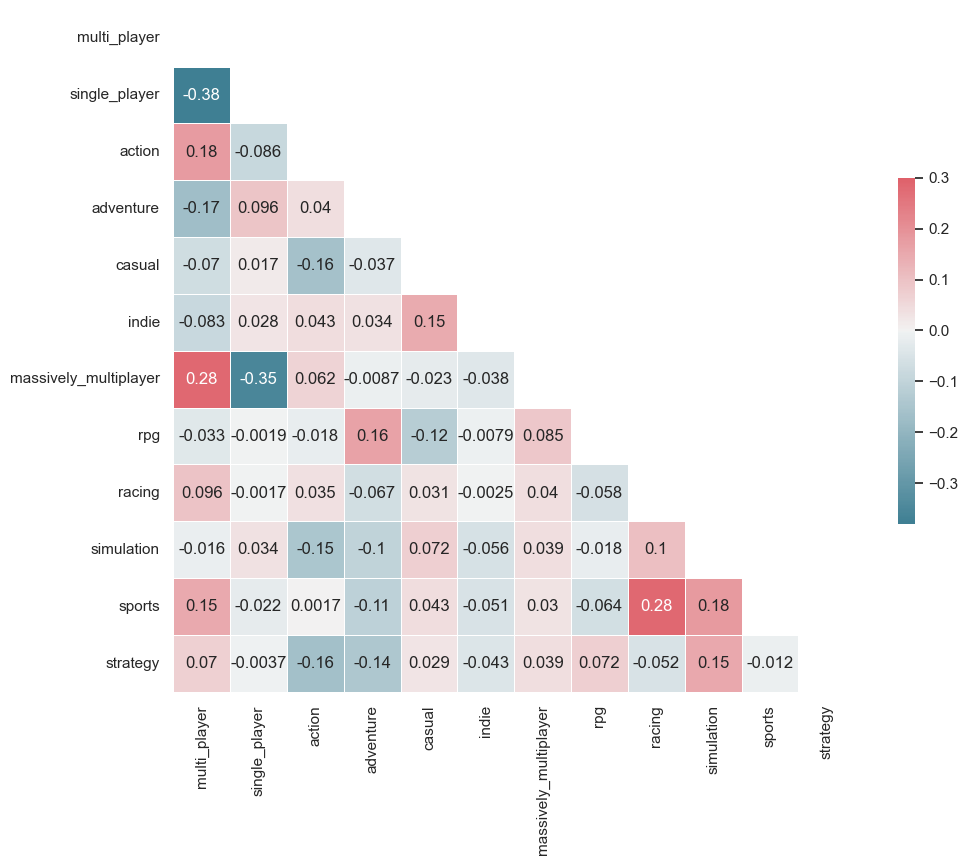

In [13]:
cat_gen_cols = df.columns[-12:]

plot_correlation_heatmap(df[cat_gen_cols])

We can see that there is correlation between different genres, which means one game can have several genres. It suggests that the high rating of a game may not depend on single genre or category, but here for simple analysis, we assume that the performance of each genres is independent.

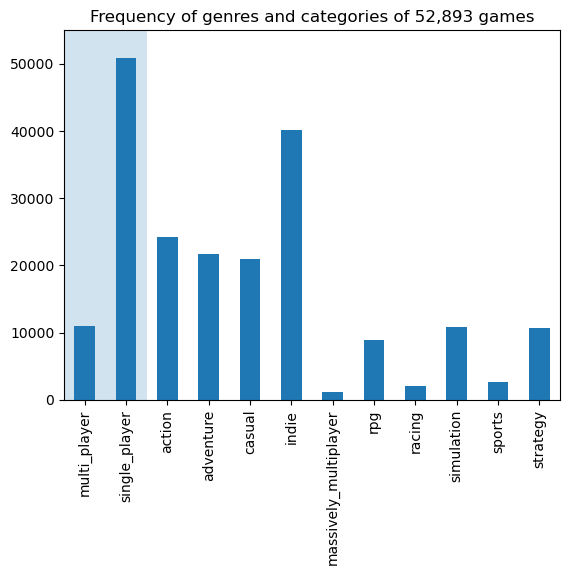

In [17]:
ax = df[cat_gen_cols].sum().plot.bar()

ax.fill_between([-.5, 1.5], 55000, alpha=.2)
ax.set_ylim([0, 55000])
ax.set_title(f'Frequency of genres and categories of {df.shape[0]:,} games')

plt.show()

Note that categorites are highlighted in blue. 

We can see that most games are categorised as 'single-player', and the genre of 'indie' takes the most percentage of all games. Also, 'massively_multiplayer', 'racing' and 'sports' games are the least.

Now, let's examine the performance of each genres based on the ratings by showing 'a rating distribution by genres'

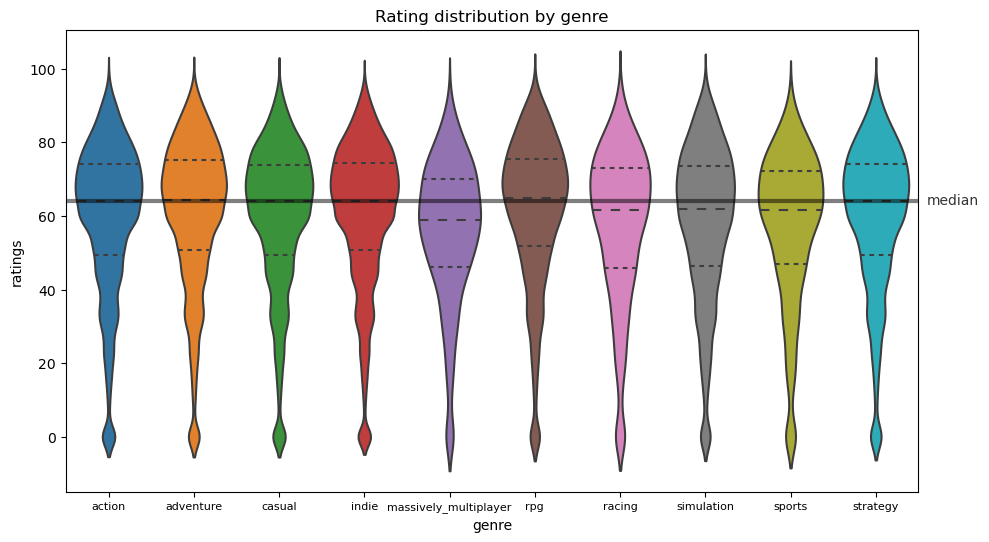

In [18]:
gen_cols = cat_gen_cols.drop(['multi_player', 'single_player'])

g_df = pd.DataFrame()

# create new dataframe with rating and genre, as games can belong to multiple genres
for col in gen_cols:
    rating = pd.DataFrame(df.loc[df[col] == 1, 'ratings'].values, columns=['ratings'])
    rating['genre'] = col
    g_df = pd.concat([g_df, rating], axis=0)

fig, ax = plt.subplots(figsize=(11,6))
sns.violinplot(x='genre', y='ratings', data=g_df, inner='quartile', ax=ax)
ax.axhline(g_df.ratings.median(), color='black', lw=3, alpha=.5)
ax.text(9.6, g_df.ratings.median()-1, 'median', color='black', alpha=.8)

ax.tick_params(axis='x', labelsize=8)
ax.set_title("Rating distribution by genre");
plt.show()

we can see that Massively Multiplayer games tend to have much lower ratings than any other genre and RPG games have slightly better ratings than most.

#### Conclusions:

1. More games are categorised as single-player, but its correlation with rating is not examined here.

2. High frequency does not mean higher ratings. Indie genre take the highest frequency, but it doesn't seem to contribute to a higher rating.

3. Massively Multiplayer games take the least proportion, and it contributes to lower ratings as well.

4. But lower frequency does not mean lower ratings. Although RPG games only take a small proportion of all games, it has a slightly higher rating than others.


## Developers and Publishers

Despite the genres and categories, we also want to see the performance of developers and publishers in correlation with ratings.

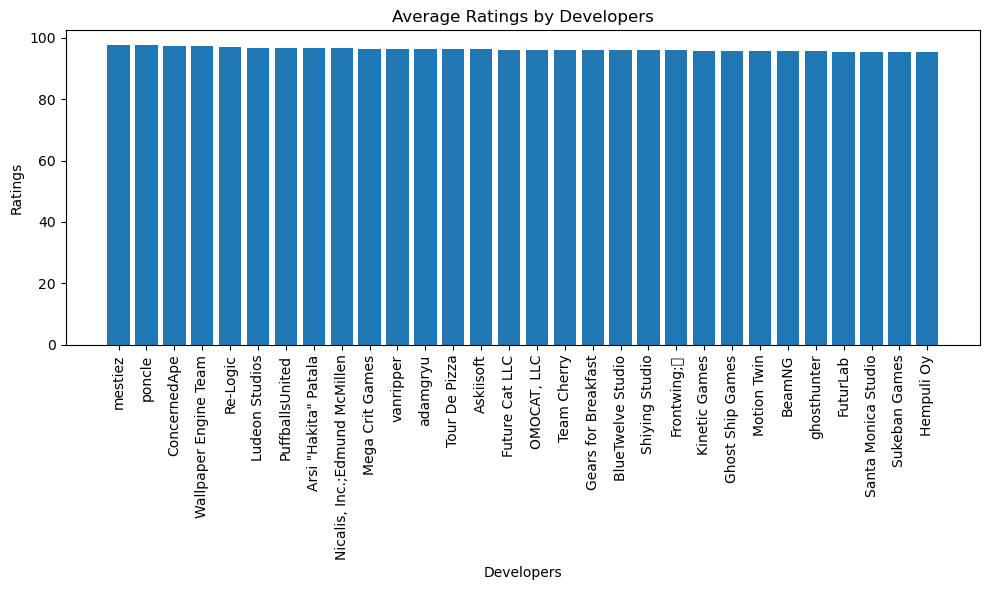

In [19]:
pv = df.pivot_table(index='developer', 
               values=['appid', 'ratings'], 
               aggfunc={'appid':'count', 'ratings':np.mean})

pv = pv.rename({'appid':'num_releases'}, axis=1).sort_values(by='ratings', ascending=False)

pv = pv.head(30)


ratings = pv['ratings']
developers = pv.index

plt.figure(figsize=(10, 6))
plt.bar(developers, ratings)
plt.xlabel('Developers')
plt.ylabel('Ratings')
plt.title('Average Ratings by Developers')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

As we can see that there is nearly no correlations between developer and ratings. It can be explained as one developer tends to develop many different genres of games, where genres seem to have greater influence on ratings.

## Owners, Pricing and Ratings

Furthermore, let's focus on some of the other relationships we observed in our initial EDA, specifically concerning the number of owners and ratings, and the price of a game and ratings.

In [15]:
display_cols = ['name', 'developer', 'publisher', 'release_year', 'genres', 'average_playtime', 'median_owners', 'ratings', 'price']
top_ten = df.sort_values(by='ratings', ascending=False).head(10)

display(top_ten[display_cols])

name              developer              publisher  \
21              Portal 2                  Valve                  Valve   
28608  People Playground                mestiez           Studio Minus   
45523  Vampire Survivors                 poncle                 poncle   
29440              Hades       Supergiant Games       Supergiant Games   
6631      Stardew Valley           ConcernedApe           ConcernedApe   
7168    Wallpaper Engine  Wallpaper Engine Team  Wallpaper Engine Team   
16                Portal                  Valve                  Valve   
986             Terraria               Re-Logic               Re-Logic   
2791            RimWorld         Ludeon Studios         Ludeon Studios   
10733    Half-Life: Alyx                  Valve                  Valve   

       release_year                                             genres  \
21             2011                                   Action;Adventure   
28608          2019                     Action;Casual;Indie;Simulation   
45523          2022                            Action;Casual;Indie;RPG   
29440          2020                                   Action;Indie;RPG   
6631           2016                               Indie;RPG;Simulation   
7168           2018  Casual;Indie;Animation & Modeling;Design & Ill...   
16             2007                                             Action   
986            2011                         Action;Adventure;Indie;RPG   
2791           2018                          Indie;Simulation;Strategy   
10733          2020                                   Action;Adventure   

       average_playtime  median_owners    ratings  price  
21                  973     15000000.0  97.697882   9.75  
28608              2895      3500000.0  97.521999   8.19  
45523              1554      7500000.0  97.499159   4.99  
29440              1843      7500000.0  97.322834  24.50  
6631               3659     15000000.0  97.305036  13.99  
7168               3638     35000000.0  97.248442   3.99  
16                  341     15000000.0  97.068921   9.75  
986                6298     35000000.0  97.036303   9.99  
2791              12092      3500000.0  96.769626  31.99  
10733               676      3500000.0  96.765972  58.99

One notable observation is that three of these games are both developed and published by Valve. It's worth mentioning that Valve is the company responsible for Steam, a digital content distribution platform primarily designed for their own games.

In addition, we could find that all of these games have achieved a significant milestone of having at least two million owners. And the price varaites from the lowest 3.99 to the highest 58.99. 

Continuing our analysis, we will now narrow our focus to paid games with 20,000 or more owners. Exploring the comparison between paid and free games could yield intriguing insights, but that discussion can be explored separately in the future.

Now, let's examine the distribution of ratings within our dataset.

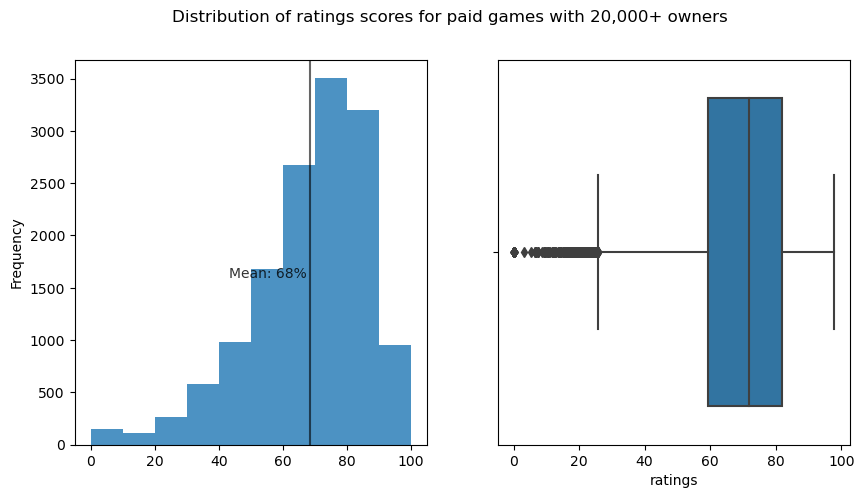

Mean ratings: 68.42%


In [16]:
warnings.filterwarnings('ignore')

# paid with over 20,000 owners
df = data[(data.median_owners >= 20000) & (data.price > 0)].copy()

fig, axarr = plt.subplots(1, 2, figsize=(10,5))

df.ratings.plot.hist(range=(0, 100), bins=10, ax=axarr[0], alpha=.8)

# plot line for mean on histogram
mean = df.ratings.mean()
axarr[0].axvline(mean, c='black', alpha=.6)
axarr[0].text(mean-1, 1600, f'Mean: {mean:.0f}%', c='black', ha='right', alpha=.8)


ax = sns.boxplot(x='ratings', data=df, orient='v', ax=axarr[1])
fig.suptitle('Distribution of ratings scores for paid games with 20,000+ owners')
plt.show()

print(f'Mean ratings: {df.ratings.mean():.2f}%')

According to the plot, we could find the distribution of ratings is left-skewed with approximately half of the ratings falling within the 60% to 80% range, which indicates games generally receive a higher proportion of positive ratings compared to negative ratings. 

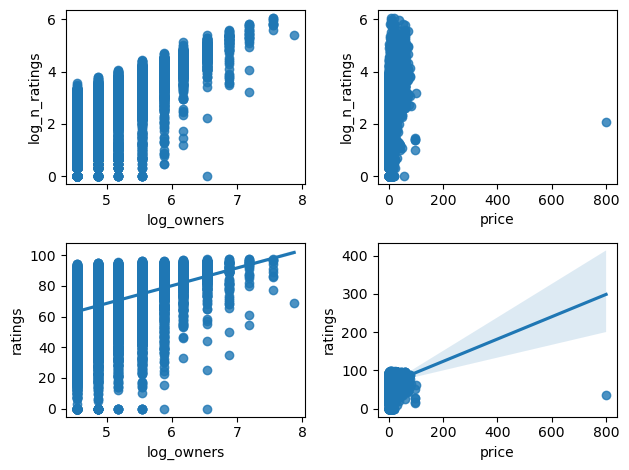

In [17]:
warnings.filterwarnings('ignore')

log_df = pd.DataFrame(zip(np.log10(df.median_owners), np.log10(df.total_ratings), df.ratings,df.price),
                      columns=['log_owners', 'log_n_ratings', 'ratings', 'price'])

fig, axarr = plt.subplots(2, 2)

sns.regplot(x='log_owners', y='log_n_ratings', data=log_df, ax=axarr[0][0])
sns.regplot(x='log_owners', y='ratings', data=log_df, ax=axarr[1][0])
sns.regplot(x='price', y='log_n_ratings', data=log_df, ax=axarr[0][1])
sns.regplot(x='price', y='ratings', data=log_df, ax=axarr[1][1])

plt.tight_layout()
plt.show()

Upon initial examination of the two plots on the left, it showed that the more owners of a game, the more times that game is likely to have been rated. The increasing tend also implays the rating score will be higher with a larger number of owners. This relationship is quite intuitive, as it is expected that better games would gain more popularity and consequently receive more positive ratings. 
There are also a few exceptions that deviate from the observed trend. It is important to note, however, even if a game receives high ratings, it doesn't guarantee that it will achieve widespread popularity. Several factors can influence the popularity of a game, such as marketing and promotion, visual and audio Appeal, continued support and updates,etc. 

For the two plots on the righ, comparing the price of a game to the number of ratings and the rating score, we could not clearly identify the relationship between price and ratings. It is probably because the rating of a game typically reflects the overall quality, gameplay experience, graphics, story, and other factors that contribute to the enjoyment and satisfaction of players. While price can be a factor that affects owners' expectations and initial interest in a game, it does not necessarily determine the actual quality or the rating it receives.

## Pricing

When analyzing the pricing aspect of this dataset, one notable limitation is the absence of the original release prices for the games. Instead, the dataset includes the current prices, which may have undergone several reductions over time, particularly for older games. Fortunately, Steam's frequent sale model has led to a trend of games maintaining higher base prices and frequently lowering them during sale events. To mitigate the impact of diminishing prices, the next section will focus exclusively on recent releases.

Now, we're going to take a quick look at the breakdown of pricing strategy for games in each genre.

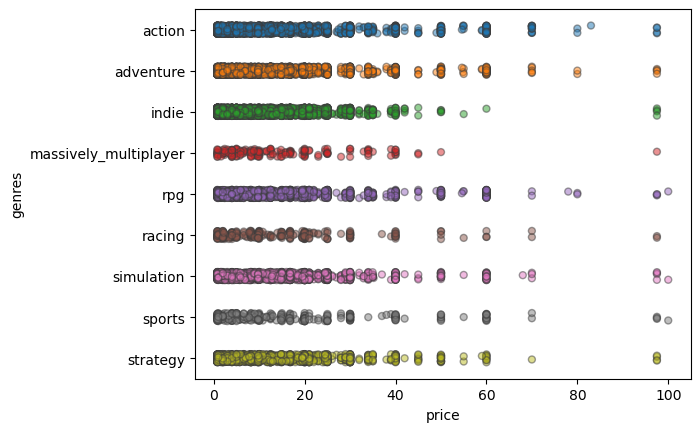

In [31]:
gen_cols = [
    'action',
    'adventure',
    'indie',
    'massively_multiplayer',
    'rpg',
    'racing',
    'simulation',
    'sports',
    'strategy'
]

g_df = pd.DataFrame()
price_df = df[df['price'] <= 200].copy() # remove extreme prices

for col in gen_cols:
    temp_df = price_df[price_df[col] == 1].copy()
    temp_df['genres'] = col
    g_df = pd.concat([g_df, temp_df], axis=0)


recent_df = g_df[g_df['release_year'] >= 2018].copy()
ax = sns.stripplot(x='price', y='genres', data=recent_df, jitter=True, alpha=.5, linewidth=1);

One conlusion we can make is that most games with main genres are priced between 0 to 40 euros, but there is no significant correlation between the two variables.